In [ ]:
import eli5
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

In [ ]:
# Ignore warnings
import warnings

warnings.filterwarnings('ignore')

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
plt.rcParams['figure.facecolor'] = 'white'
pd.set_option('display.float_format', '{:.3f}'.format)

# Load data

In [34]:
df = pd.read_csv("healthcare_dataset.csv", parse_dates=['Date of Admission', 'Discharge Date'])

In [35]:
df.shape

(10000, 15)

# EDA

In [36]:
df.describe()

,Age,Date of Admission,Billing Amount,Room Number,Discharge Date
count,10000.000,10000,10000.000,10000.000,10000
mean,51.452,2021-05-01 21:53:25.439999744,25516.807,300.082,2021-05-17 11:22:24.960000
min,18.000,2018-10-30 00:00:00,1000.181,101.000,2018-11-01 00:00:00
25%,35.000,2020-02-10 00:00:00,13506.524,199.000,2020-02-23 18:00:00
50%,52.000,2021-05-02 00:00:00,25258.113,299.000,2021-05-18 00:00:00
75%,68.000,2022-07-23 06:00:00,37733.914,400.000,2022-08-07 00:00:00
max,85.000,2023-10-30 00:00:00,49995.902,500.000,2023-11-27 00:00:00
std,19.589,NaN,14067.293,115.806,NaN


In [37]:
df.select_dtypes('object').head()

,Name,Gender,Blood Type,Medical Condition,Doctor,Hospital,Insurance Provider,Admission Type,Medication,Test Results
0,Tiffany Ramirez,Female,O-,Diabetes,Patrick Parker,Wallace-Hamilton,Medicare,Elective,Aspirin,Inconclusive
1,Ruben Burns,Male,O+,Asthma,Diane Jackson,"Burke, Griffin and Cooper",UnitedHealthcare,Emergency,Lipitor,Normal
2,Chad Byrd,Male,B-,Obesity,Paul Baker,Walton LLC,Medicare,Emergency,Lipitor,Normal
3,Antonio Frederick,Male,B-,Asthma,Brian Chandler,Garcia Ltd,Medicare,Urgent,Penicillin,Abnormal
4,Mrs. Brandy Flowers,Male,O-,Arthritis,Dustin Griffin,"Jones, Brown and Murray",UnitedHealthcare,Urgent,Paracetamol,Normal


In [38]:
(df.select_dtypes('object').nunique() / df.shape[0]).to_dict()

{'Name': 0.9378,
 'Gender': 0.0002,
 'Blood Type': 0.0008,
 'Medical Condition': 0.0006,
 'Doctor': 0.9416,
 'Hospital': 0.8639,
 'Insurance Provider': 0.0005,
 'Admission Type': 0.0003,
 'Medication': 0.0005,
 'Test Results': 0.0003}

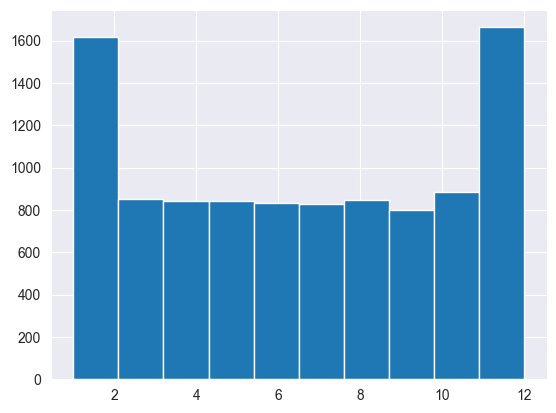

In [40]:
df['Date of Admission'].dt.month.hist()

# plt.xticks(rotation=90)
plt.show()

In [24]:
df.isna().sum()

Name                  0
Age                   0
Gender                0
Blood Type            0
Medical Condition     0
Date of Admission     0
Doctor                0
Hospital              0
Insurance Provider    0
Billing Amount        0
Room Number           0
Admission Type        0
Discharge Date        0
Medication            0
Test Results          0
dtype: int64

array([[<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Billing Amount'}>],
       [<Axes: title={'center': 'Room Number'}>, <Axes: >]], dtype=object)

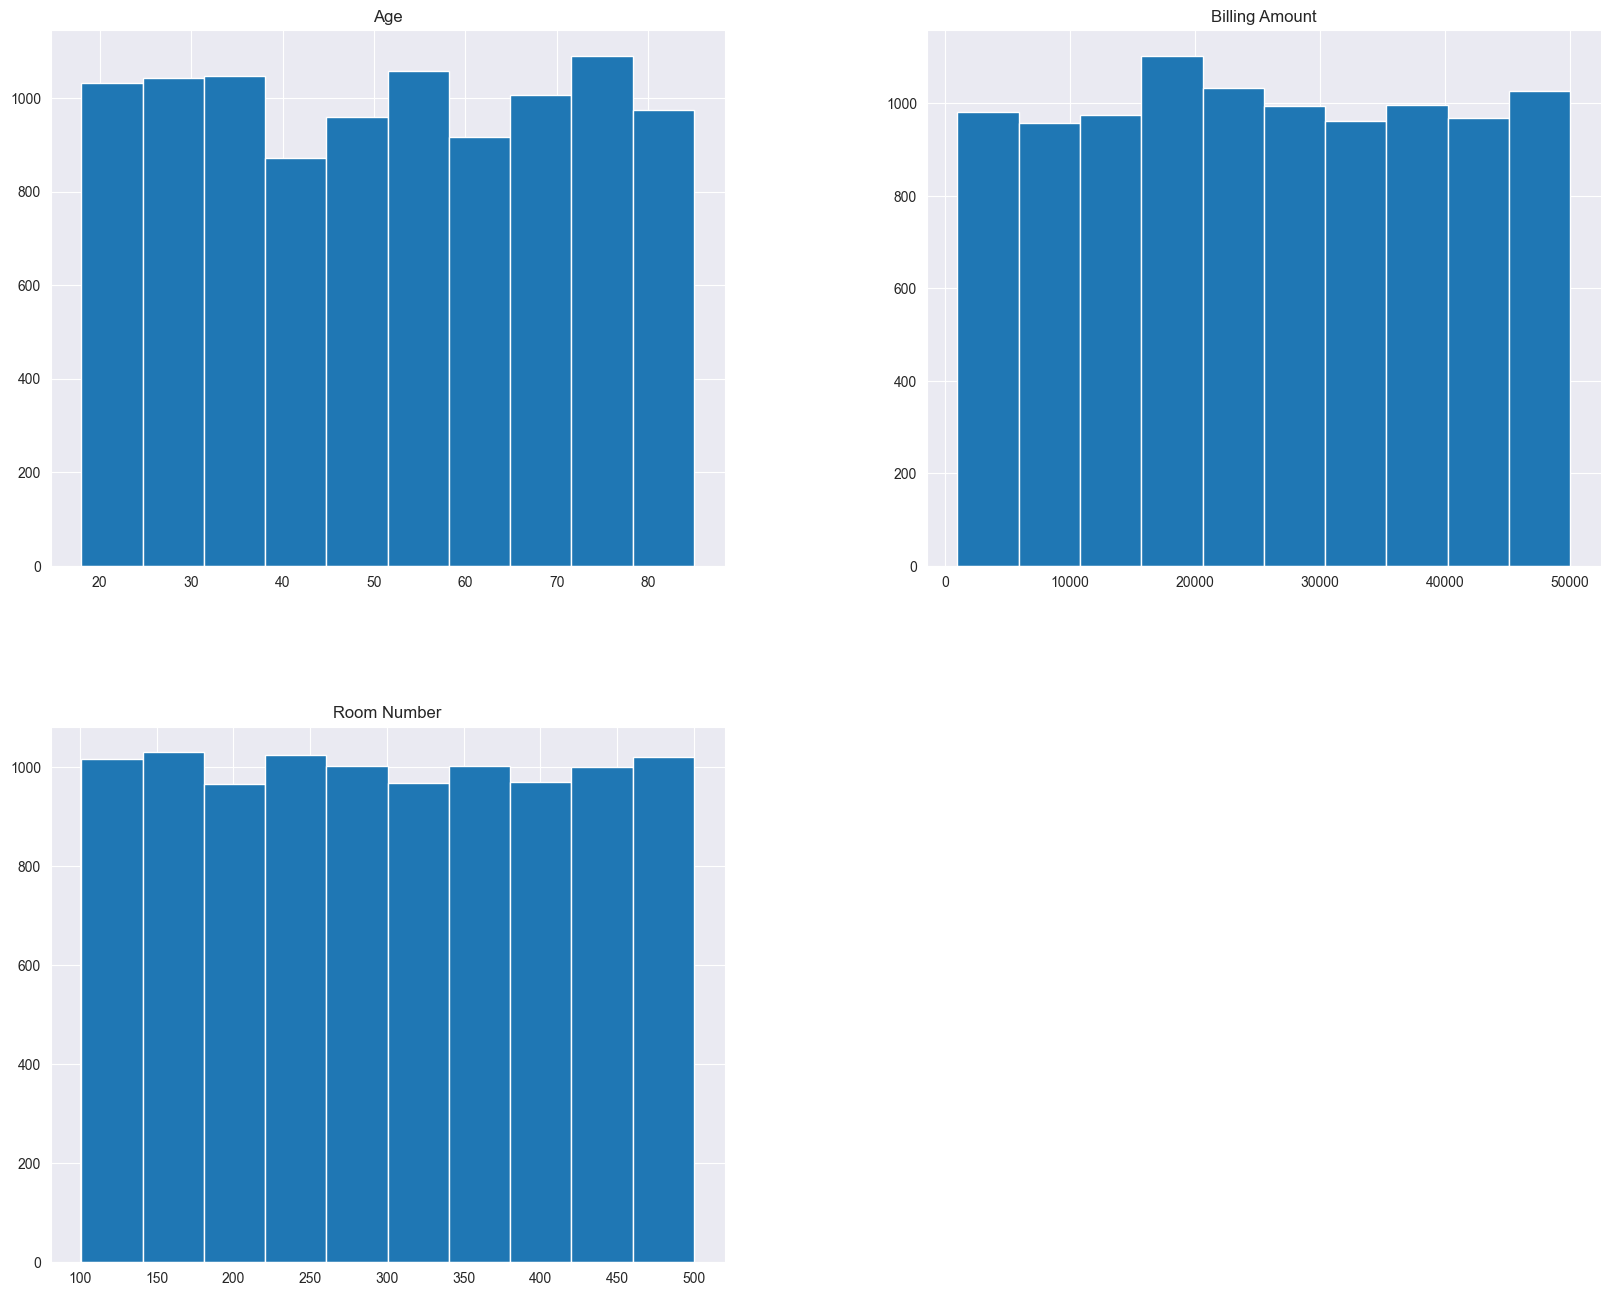

In [14]:
df.hist(figsize=[20, 16])

In [ ]:
for f in df.select_dtypes('object'):
    if df[f].nunique() / df.shape[0] < 0.18:
        df[f].hist()

        plt.show()

In [ ]:
# Target

In [15]:
target_name = 'Test Results'

<Axes: >

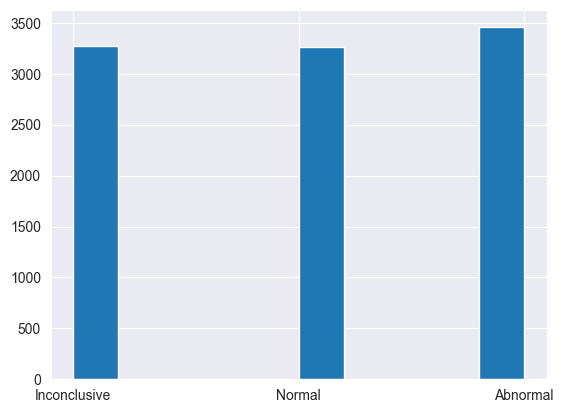

In [17]:
df[target_name].hist()

# Features

# Feature creation

In [46]:
df['admit_weekday'] = df['Date of Admission'].dt.weekday
df['admit_month'] = df['Date of Admission'].dt.month

# Feature selection

In [172]:
removed_cols = [
    target_name,

    'Name',  # useless
    'Room Number',  # useless
    'Doctor',  # too many categories -> leak
    'Hospital',  # too many categories -> leak
    'Date of Admission',  # processed
    'Discharge Date',  # leak
    'Billing Amount',  # leak
]

categorical = [
    # original
    'Gender',
    'Blood Type',
    'Medical Condition',
    'Insurance Provider',
    'Admission Type',
    'Medication',

    # created
    'admit_weekday',
    'admit_month',
]

numerical = [
    'Age',
]

In [173]:
all_columns = [f for f in df if f not in removed_cols]

# Train, test, validation splits

In [174]:
from sklearn.model_selection import train_test_split

In [175]:
X_train, X_test, y_train, y_test = train_test_split(
    df[all_columns],
    df[target_name].map({
        'Abnormal': 2,
        'Inconclusive': 1,
        'Normal': 0,
    }),
    test_size=0.3,
    random_state=42,
    stratify=df[target_name],
)

In [176]:
y_train.value_counts()

Test Results
2    2419
1    2294
0    2287
Name: count, dtype: int64

In [177]:
y_test.value_counts()

Test Results
2    1037
1     983
0     980
Name: count, dtype: int64

# processing pipeline

In [184]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Numeric Transformer: Imputation + Scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),  # strategy='median'
    ('scaler', StandardScaler()),
])

# Categorical Transformer: One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    # ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ('enc', TargetEncoder(target_type='continuous')),
])

# Combine both Numeric and Categorical transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical),
        ('cat', categorical_transformer, categorical),
    ],
    remainder='drop'  # Columns not specified will be passed through
)

# Final pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)]).set_output(transform='pandas')


In [185]:
X_train_transformed = pipeline.fit_transform(
    X_train,
    y_train)

In [186]:
X_test_transformed = pipeline.transform(X_test)

# Fit

In [187]:
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, cohen_kappa_score, \
    classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.metrics import confusion_matrix




# Initialize models list
models = [
    ('Dummy', DummyClassifier(strategy="stratified", random_state=42)),
    ('RandomForest', RandomForestClassifier(random_state=42)),
    ('LightGBM', LGBMClassifier(random_state=42)),
    ('XGBoost', XGBClassifier(random_state=42)),
    ('LogisticRegression', LogisticRegression(random_state=42)),
    ('Ridge', RidgeClassifier(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('NN', MLPClassifier(random_state=42))
]

# Initialize an empty list to store metrics
metrics_list = []

# Loop through models
for name, model in models:
    # Fit the model
    model.fit(X_train_transformed, y_train)

    # Initialize dict for this model's metrics
    model_metrics = {'Model': name}

    print('#' * 64)
    print(name)
    for dataset, X, y in [
        ('Train', X_train_transformed, y_train),
        ('Test', X_test_transformed, y_test),
    ]:
        # Make predictions
        y_pred = model.predict(X)
        try:
            y_prob = model.predict_proba(X)[:, 1]
        except AttributeError:
            print(f'Model {name} has no predict_proba. Hard prediction used')
            y_prob = y_pred

        # Compute metrics
        f1 = f1_score(y, y_pred, average='weighted')
        precision = precision_score(y, y_pred, average='weighted')
        recall = recall_score(y, y_pred, average='weighted')
        # auc = roc_auc_score(y, y_prob, multi_class='ovr')
        kappa = cohen_kappa_score(y, y_pred)

        print(dataset)
        print(classification_report(y, y_pred))
        print(confusion_matrix(y, y_pred))

        # Append metrics to dict
        model_metrics.update({
            f'{dataset}_F1_Score': f1,
            f'{dataset}_Precision': precision,
            f'{dataset}_Recall': recall,
            # f'{dataset}_AUC': auc,
            f'{dataset}_Kappa': kappa
        })

    # Append model metrics to list
    metrics_list.append(model_metrics)

# Convert list of metrics to DataFrame
metrics_df = pd.DataFrame(metrics_list, index=[i[0] for i in models])

################################################################
Dummy
Train
              precision    recall  f1-score   support

           0       0.32      0.31      0.32      2287
           1       0.33      0.34      0.34      2294
           2       0.35      0.35      0.35      2419

    accuracy                           0.34      7000
   macro avg       0.34      0.34      0.34      7000
weighted avg       0.34      0.34      0.34      7000

[[709 761 817]
 [733 791 770]
 [746 817 856]]
Test
              precision    recall  f1-score   support

           0       0.32      0.31      0.32       980
           1       0.32      0.33      0.32       983
           2       0.34      0.34      0.34      1037

    accuracy                           0.33      3000
   macro avg       0.33      0.33      0.33      3000
weighted avg       0.33      0.33      0.33      3000

[[306 339 335]
 [311 321 351]
 [338 346 353]]
################################################################

In [188]:
metrics_df[[f for f in metrics_df if 'Test' in f]]

,Test_F1_Score,Test_Precision,Test_Recall,Test_Kappa
Dummy,0.327,0.327,0.327,-0.010
RandomForest,0.337,0.338,0.339,0.007
LightGBM,0.326,0.329,0.331,-0.006
XGBoost,0.326,0.338,0.343,0.009
LogisticRegression,0.261,0.337,0.340,-0.001
Ridge,0.278,0.327,0.337,-0.005
KNN,0.327,0.337,0.335,0.005
NN,0.296,0.317,0.320,-0.015


In [189]:
metrics_df[[f for f in metrics_df if 'Train' in f]]

,Train_F1_Score,Train_Precision,Train_Recall,Train_Kappa
Dummy,0.336,0.336,0.337,0.004
RandomForest,1.000,1.000,1.000,1.000
LightGBM,0.798,0.800,0.798,0.697
XGBoost,0.955,0.955,0.955,0.933
LogisticRegression,0.288,0.365,0.354,0.021
Ridge,0.305,0.345,0.352,0.020
KNN,0.555,0.574,0.558,0.339
NN,0.315,0.345,0.337,0.012


# Explain

## Eli5

In [190]:
import eli5
print(eli5.explain_weights_df(models[1][1], feature_names=list(X_train_transformed.columns)).to_string())

                   feature  weight   std
0                 num__Age   0.177 0.011
1         cat__admit_month   0.139 0.013
2       cat__admit_weekday   0.117 0.012
3   cat__Medical Condition   0.113 0.009
4          cat__Blood Type   0.113 0.014
5          cat__Medication   0.105 0.009
6  cat__Insurance Provider   0.097 0.015
7      cat__Admission Type   0.079 0.009
8              cat__Gender   0.059 0.009


## LIME

In [191]:
from lime.lime_tabular import LimeTabularExplainer

In [192]:
explainer = LimeTabularExplainer(
    X_train_transformed.values,
    feature_names=list(X_train_transformed.columns),
    class_names=['normal', 'anomaly'],
    discretize_continuous=True,
)

In [193]:
exp = explainer.explain_instance(X_train_transformed.iloc[0], models[4][1].predict_proba)

In [194]:
models[4][1].predict_proba(X_train_transformed.iloc[:1])

array([[0.34002216, 0.32103053, 0.33894731]])

Figure(640x480)


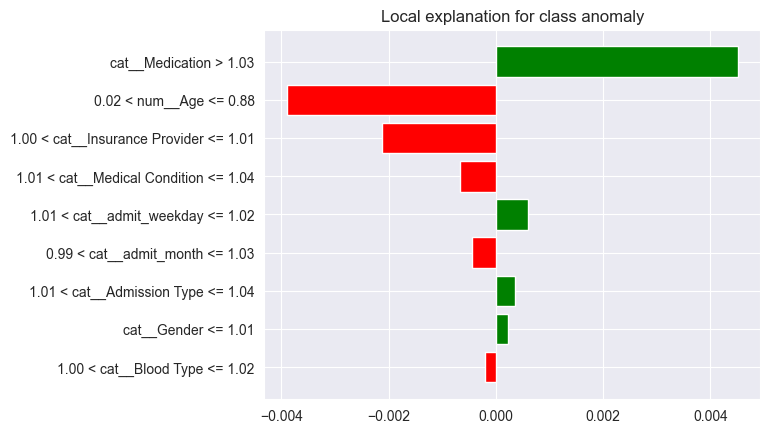

In [195]:
print(exp.as_pyplot_figure())

In [196]:
exp.as_list()

[('cat__Medication > 1.03', 0.004513178986848063),
 ('0.02 < num__Age <= 0.88', -0.0038938528637870646),
 ('1.00 < cat__Insurance Provider <= 1.01', -0.0021192597516421436),
 ('1.01 < cat__Medical Condition <= 1.04', -0.0006724408141014891),
 ('1.01 < cat__admit_weekday <= 1.02', 0.000604977767251228),
 ('0.99 < cat__admit_month <= 1.03', -0.0004445040704791916),
 ('1.01 < cat__Admission Type <= 1.04', 0.0003528217858193572),
 ('cat__Gender <= 1.01', 0.00022772459428391898),
 ('1.00 < cat__Blood Type <= 1.02', -0.0002081896966256411)]

# tsne

In [202]:
from sklearn.manifold import TSNE

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(X_train_transformed[[f for f in X_train_transformed if 'admit' not in f]])

In [203]:
# Create a DataFrame to hold the t-SNE results
df_tsne = pd.DataFrame(data=tsne_results, columns=['Dimension 1', 'Dimension 2'])
df_tsne['target'] = y_train

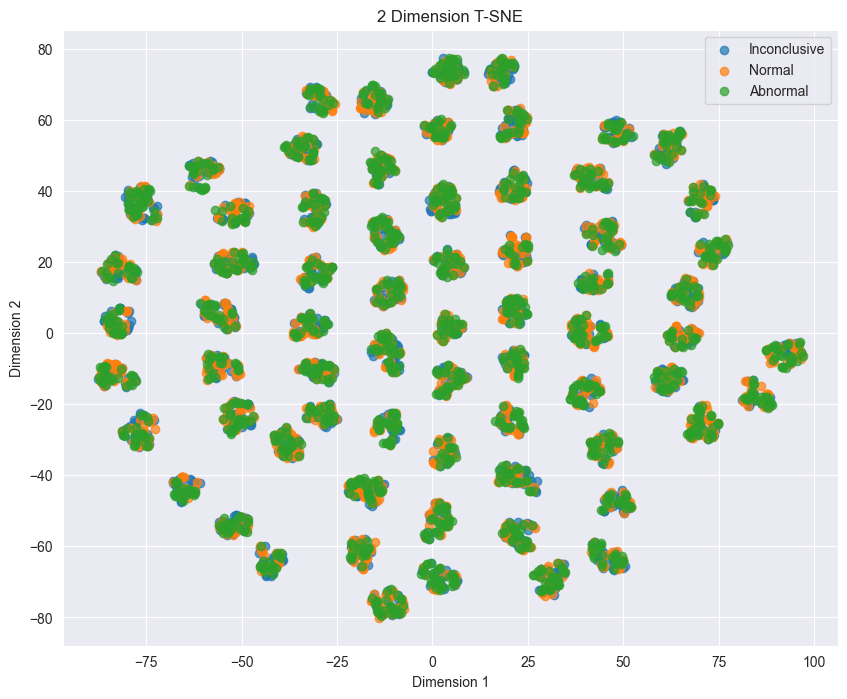

In [204]:
import numpy as np

plt.figure(figsize=(10, 8))

# Plot each category
for label in np.unique(df_tsne['target']):

    plt.scatter(
        df_tsne.loc[df_tsne.target == label]['Dimension 1'],
        df_tsne.loc[df_tsne.target == label]['Dimension 2'],
        label=label,
        alpha=0.7
    )

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2 Dimension T-SNE')
plt.legend(df[target_name].unique())
plt.show()